# Práctica 4

Se dejó lo principal del notebook original, con algunas modificaciones. La función `preprocess_text()` se encuentra en el archivo `preprocessing.py`.

In [1]:
import pandas as pd
from preprocessing import preprocess_text

df = pd.read_csv("spam_ham_dataset.csv")

# Obtenemos 4 listas, texto completo, etiquetas, spam y ham
texto = df["text"]
labels = df["label_num"]
spam = df[df["label_num"]==1]["text"]
ham = df[df["label_num"]==0]["text"]

# Aplicamos la funcion anterior a cada elemento de las listas con texto
texto_2 = [preprocess_text(email) for email in texto]

spam_2 = [preprocess_text(email) for email in spam]
ham_2 = [preprocess_text(email) for email in ham]

# Obtenemos el conjunto de palabras unicas de spam
set_spam = set()
for email in spam_2:
  set_spam.update(set(email))

# Obtenemos el conjunto de palabras unicas de ham
set_ham = set()
for email in ham_2:
  set_ham.update(set(email))

[nltk_data] Downloading package stopwords to /home/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/luis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


En vez de usar listas para verificar la pertenencia, se prefirió usar conjuntos, lo que nos ayuda a bajar la complejidad y realizar los cálculos más rápidos.

In [2]:
spam_email = [ set(email) for email in spam_2 ]
ham_email = [ set(email) for email in ham_2 ]

In [3]:
dict_spamicity = {}
#Obtenemos la proba de que aparezca una palabra dado que es spam
#Iteramos sobre las palabras que aparecen en spam
# Iteramos sobre los correos de spam
total_spam = len(spam)
for palabra in set_spam:
  pInSpam = 0
  for email in spam_email:
    if palabra in email:
      pInSpam +=1
  if pInSpam ==0:
    proba = 1/total_spam # Parametro
  else:
    proba = pInSpam/total_spam
  dict_spamicity[palabra] = proba


In [5]:
dict_ham = {}
#Obtenemos la proba de que aparezca una palabra dado que es ham
#Iteramos sobre las palabras que aparecen en ham
# Iteramos sobre los correos de ham
total_ham = len(ham)
for palabra in set_ham:
  pInHam = 0
  for email in ham_email:
    if palabra in email:
      pInHam +=1
  if pInHam ==0:
    proba = 1/total_ham # Parametro
  else:
    proba = pInHam/total_ham
  dict_ham[palabra] = proba

In [ ]:
# Calculamos la proba de spam
S = total_spam/(total_spam+total_ham)
# Calculamos la proba de ham
H = total_ham/(total_spam+total_ham)

Aquí realizamos una especie de _smoothing_, que por defecto estaba en `1/total_spam` o `1/total_ham`. En vez de eso, se optó por un valor más pequeño, pues el valor anterior era demasiado grande.

In [ ]:
# Creamos funcion que reciba una lista de probabilidades, multiplique todas y regrese el resultado
def mult(probas) :        # multiplicar todas las probas
    total_prob = 1
    for proba in probas:
      total_prob*=proba
    # Multiplicar todas las probas
    return total_prob
# Creamos funcion que aplique Naive_Bayes a un email, con un threshold como parametro
def Naive_Bayes(email,threshold):
    probs = []
    S # prob_spam
    H # prob_ham
    # Iteramos sobre las palabras del email
    for palabra in email:

    # Calculamos la proba de PdadoS #*Si es 0 asignamos una probabilidad baja 1/(total_spam+2)
      try:
        PdadoS = dict_spamicity[palabra]
      except:
        PdadoS = 0.00001/total_spam
    # Calculamos la proba de PdadoH #*Si es 0 asignamos una probabilidad baja 1/(total_spam+2)
      try:
          PdadoH = dict_ham[palabra]
      except:
          PdadoH = 0.00001/total_ham
    # Aplicamos Bayes para obtener SdadoP
      probaB = PdadoS*S/(PdadoS*S+ PdadoH*H)
      probs.append(probaB)
    # Multiplicamos todas las probas para obtener el total de SdadoEmail
    SdadoEmail = mult(probs)
    # Aplicamos el Threshold para determinar si es o no es spam
    # print(SdadoEmail)
    if SdadoEmail >= threshold:
      SdadoEmail =1
    else:
      SdadoEmail = 0
    return SdadoEmail


In [ ]:
# Preparamos tests para medir metricas
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(texto_2, labels, test_size=0.33, random_state=42)


In [ ]:
y_pred = [Naive_Bayes(email,.00000000000001) for email in X_test]

from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1246
           1       0.87      0.53      0.66       461

    accuracy                           0.85      1707
   macro avg       0.86      0.75      0.78      1707
weighted avg       0.85      0.85      0.84      1707



Text(0.5, 1.0, 'Confusion Matrix')

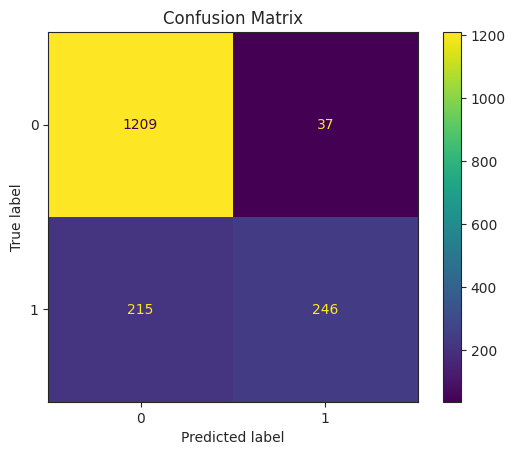

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
plt.title("Confusion Matrix")

## Resultados

Como dicho anteriormente, a los dos se les aplicó el mismo _smoothing_ en el cálculo de Bayes Naïve. El valor del umbral fue `threshold = .00000000000001`. Se obtuvieron los siguientes resultados: 

**Con procesamiento del lenguaje natural**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     |   0.85    |  0.97  |   0.91   |  1246   |
| 1     |   0.87    |  0.53  |   0.66   |   461   |

accuracy: 0.85

**Sin procesamiento del lenguaje natural**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     |   0.77    |  0.99  |   0.87   |  1246   |
| 1     |   0.87    |  0.21  |   0.33   |   461   |

accuracy: 0.78

El valor de _accuracy_ mejoró por .08 puntos. Respecto a las métricas por cada clase, mejoró _precision_ para ham y _recall_ para spam, este último de gran utilidad si la tarea a realizar es detectar spam. Por lo tanto, este modelo (el que utiliza procesamiento del lenguaje natural) es ligeramente superior al anterior.